# Correlating 2 measures

We will explore how we can determine if 2 measures are correlated

![test_correlation.png](images/test_correlation.png)

---
## Data preparation

We will use a dataset from https://github.com/kkholst/mets based on a study of 7245 same-sexed Finnish MZ and DZ twin pairs aged 18-54 years from the nationwide Finnish Twin Cohort

A subset of the dataset includes
- `gender`: male/female
- `zyg`: whether monozygotic (MZ) or dizygotic (DZ) twins
- `bmi`: body mass index

In [1]:
library(tidyverse)

# Twin data from https://github.com/kkholst/mets
data <- read_csv("https://raw.githubusercontent.com/kennethban/dataset/main/twinbmi.csv")

data <- data %>% 
        mutate(gender = as.factor(gender),
                  zyg = as.factor(zyg)) %>%
        pivot_wider(id_cols ="tvparnr", 
                    names_from = "num", 
                    values_from = c("bmi","gender","zyg")) %>%
        rename(twinid = tvparnr, 
               zyg = zyg_1) %>%
        select(-zyg_2) %>%
        drop_na()

data %>% sample_n(10)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Rows: 11188 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): gender, zyg
dbl (5): tvparnr, bmi, age, id, num

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


twinid,bmi_1,bmi_2,gender_1,gender_2,zyg
<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>
4290,22.76944,20.93212,female,female,MZ
1844,27.71769,28.05571,male,male,MZ
932,28.73175,26.70362,male,male,MZ
3703,26.56250,29.21011,female,female,DZ
3238,21.13271,23.14815,male,male,MZ
636,26.23457,26.87450,male,male,MZ
960,26.44898,24.62296,male,male,DZ
4874,20.57613,20.57613,female,female,MZ
5167,23.72529,22.48133,female,female,DZ


To illustrate how we can test for correlation, we will focus on the monozygotic twins to reduce the number of samples

In [2]:
data_mz <- data %>%
           filter(zyg=="MZ")

head(data_mz)

twinid,bmi_1,bmi_2,gender_1,gender_2,zyg
<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>
13,30.36735,31.63740,male,male,MZ
16,22.72044,22.12974,male,male,MZ
28,22.32143,24.09297,male,male,MZ
29,23.58833,23.50780,male,male,MZ
31,23.29123,24.22023,male,male,MZ
35,22.83737,24.91349,male,male,MZ


We can show a scatterplot of the 2 measures

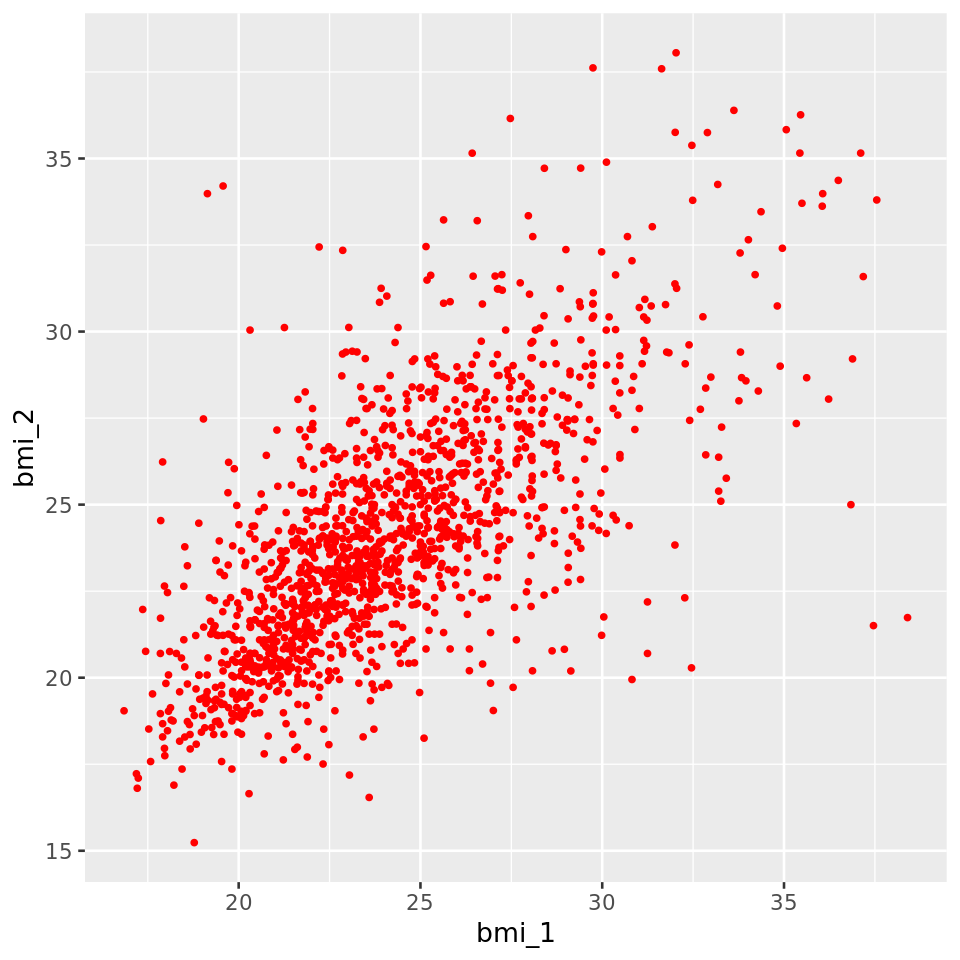

In [3]:
# set plot dimensions
options(repr.plot.width=8, repr.plot.height=8)

data_mz %>% 
ggplot(aes(x=bmi_1, y=bmi_2)) +
  geom_point(color="red") +
  theme_grey(base_size=16) +
  theme(legend.position = "top")

By visual inspection, there appears to be a correlation between BMI values from one twin and the other twin. However, we may not be sure if this correlation could have occurred by random chance

---
## How can we quantify correlation?

We can consider how 2 values (X and Y) are correlated by looking at the ratio of how much X and Y vary together to the how much they vary independently. 


$$\begin{aligned}
r_{X Y} &=\frac{\text { Degree to which } X \text { and } Y \text { vary together }}{\text { Degree to which } X \text { and } Y \text { vary separately }} \\
&=\frac{\operatorname{Cov}(X, Y)}{\sqrt{\operatorname{Var}(X)} \sqrt{\operatorname{Var}(Y)}} \\
&=\frac{\sum_{i=1}^{n}\left(x_{i}-\bar{x}\right)\left(y_{i}-\bar{y}\right)/n-1}{\sqrt{\sum_{i=1}^{n}\left(x_{i}-\bar{x}\right)^{2}/n-1} \sqrt{\sum_{i=1}^{n}\left(y_{i}-\bar{y}\right)^{2}/n-1}} \\
&=\frac{\sum_{i=1}^{n}\left(x_{i}-\bar{x}\right)\left(y_{i}-\bar{y}\right)}{\sqrt{\sum_{i=1}^{n}\left(x_{i}-\bar{x}\right)^{2} \sum_{i=1}^{n}\left(y_{i}-\bar{y}\right)^{2}}}
\end{aligned}$$


The correlation coefficient $r$  can vary from -1 to 1 depending on the direction of correlation

![test_correlation_r.png](images/test_correlation_r.png)


In [4]:
data_mz %>% 
summarize(n = n(),
          mean_bmi_1 = mean(bmi_1),
          mean_bmi_2 = mean(bmi_2),
          covariance_xy = sum((bmi_1-mean_bmi_1)*(bmi_2-mean_bmi_2))/(n-1),
          variance_x = sqrt(sum((bmi_1-mean_bmi_1)^2)/(n-1)),
          variance_y = sqrt(sum((bmi_2-mean_bmi_2)^2)/(n-1)),
          r = covariance_xy/(variance_x * variance_y)
         )

n,mean_bmi_1,mean_bmi_2,covariance_xy,variance_x,variance_y,r
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1483,24.2098,24.16305,8.581417,3.591942,3.492014,0.6841538


**Using a function**

We can use the `cor_test` function from the `rstatix` library

In [5]:
data_mz %>% 
rstatix::cor_test(bmi_1, bmi_2) %>%
pull(cor)

cor 
0.68

---
## 1. Resampling approach

To get an intuition of the null hypothesis test, we can use the resampling approach
- To do this, we randomly mix the values between the 2 groups and do this multiple times to generate a _dataset that represents the null hypothesis_
- We then calculate the correlation coefficient for each permutation generated by random mixing to generate the null distribution of values
- Finally, we calculate the _p-value_, which is the probability we  find a correlation coefficient in the null distribution that is equal/greater than the correlation coefficient observed in the data

$$P(\text{Data}|\text{Null distribution})$$

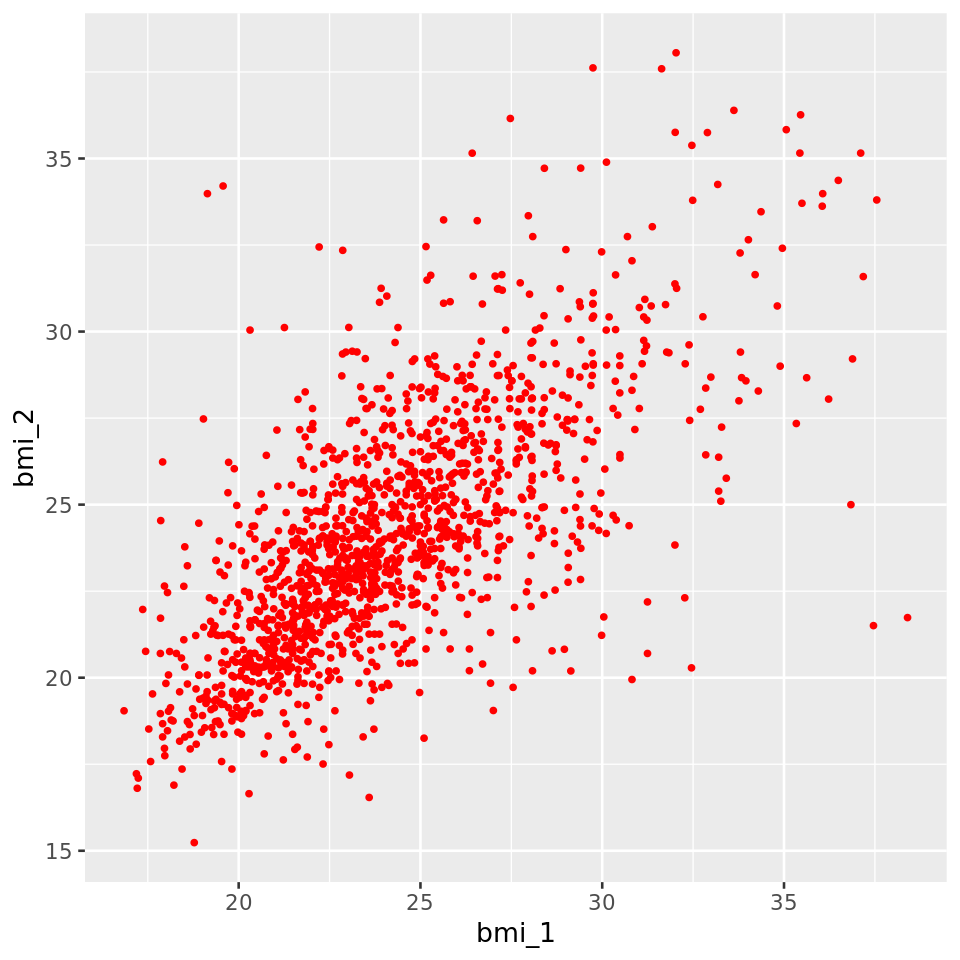

In [6]:
# set plot dimensions
options(repr.plot.width=8, repr.plot.height=8)

data_mz %>% 
ggplot(aes(x=bmi_1, y=bmi_2)) +
  geom_point(color="red") +
  theme_grey(base_size=16) +
  theme(legend.position = "top")

### 1.1. Calculate the test statistic

We calculate the r statistic using the `cor_test` function from the `rstatix` library

In [7]:
obs_stat_r <- data_mz %>% 
              rstatix::cor_test(bmi_1, bmi_2) %>%
              pull(cor)
obs_stat_r

cor 
0.68

### 1.2. Generate a null distribution by resampling

First, we will generate 1000 samples from the data by randomly permuting the `bmi_1` and `bmi_2` values independently using the `infer` library

In [8]:
library(infer)

num_resamples = 1000

permute <- data %>%
           specify(bmi_2 ~ bmi_1) %>%
           hypothesize(null="independence") %>%
           generate(reps=num_resamples, type="permute")

head(permute)
tail(permute)

bmi_2,bmi_1,replicate
<dbl>,<dbl>,<int>
19.95728,26.33289,1
25.64892,27.25089,1
30.77870,28.04282,1
33.07829,28.06642,1
21.41095,30.47797,1
37.59238,27.39818,1


bmi_2,bmi_1,replicate
<dbl>,<dbl>,<int>
23.83673,26.34649,1000
25.95156,31.77393,1000
24.38237,21.35991,1000
25.14742,24.74745,1000
19.81405,19.37716,1000
23.63403,20.06096,1000


We can plot a sample of the randomly permuted dataset

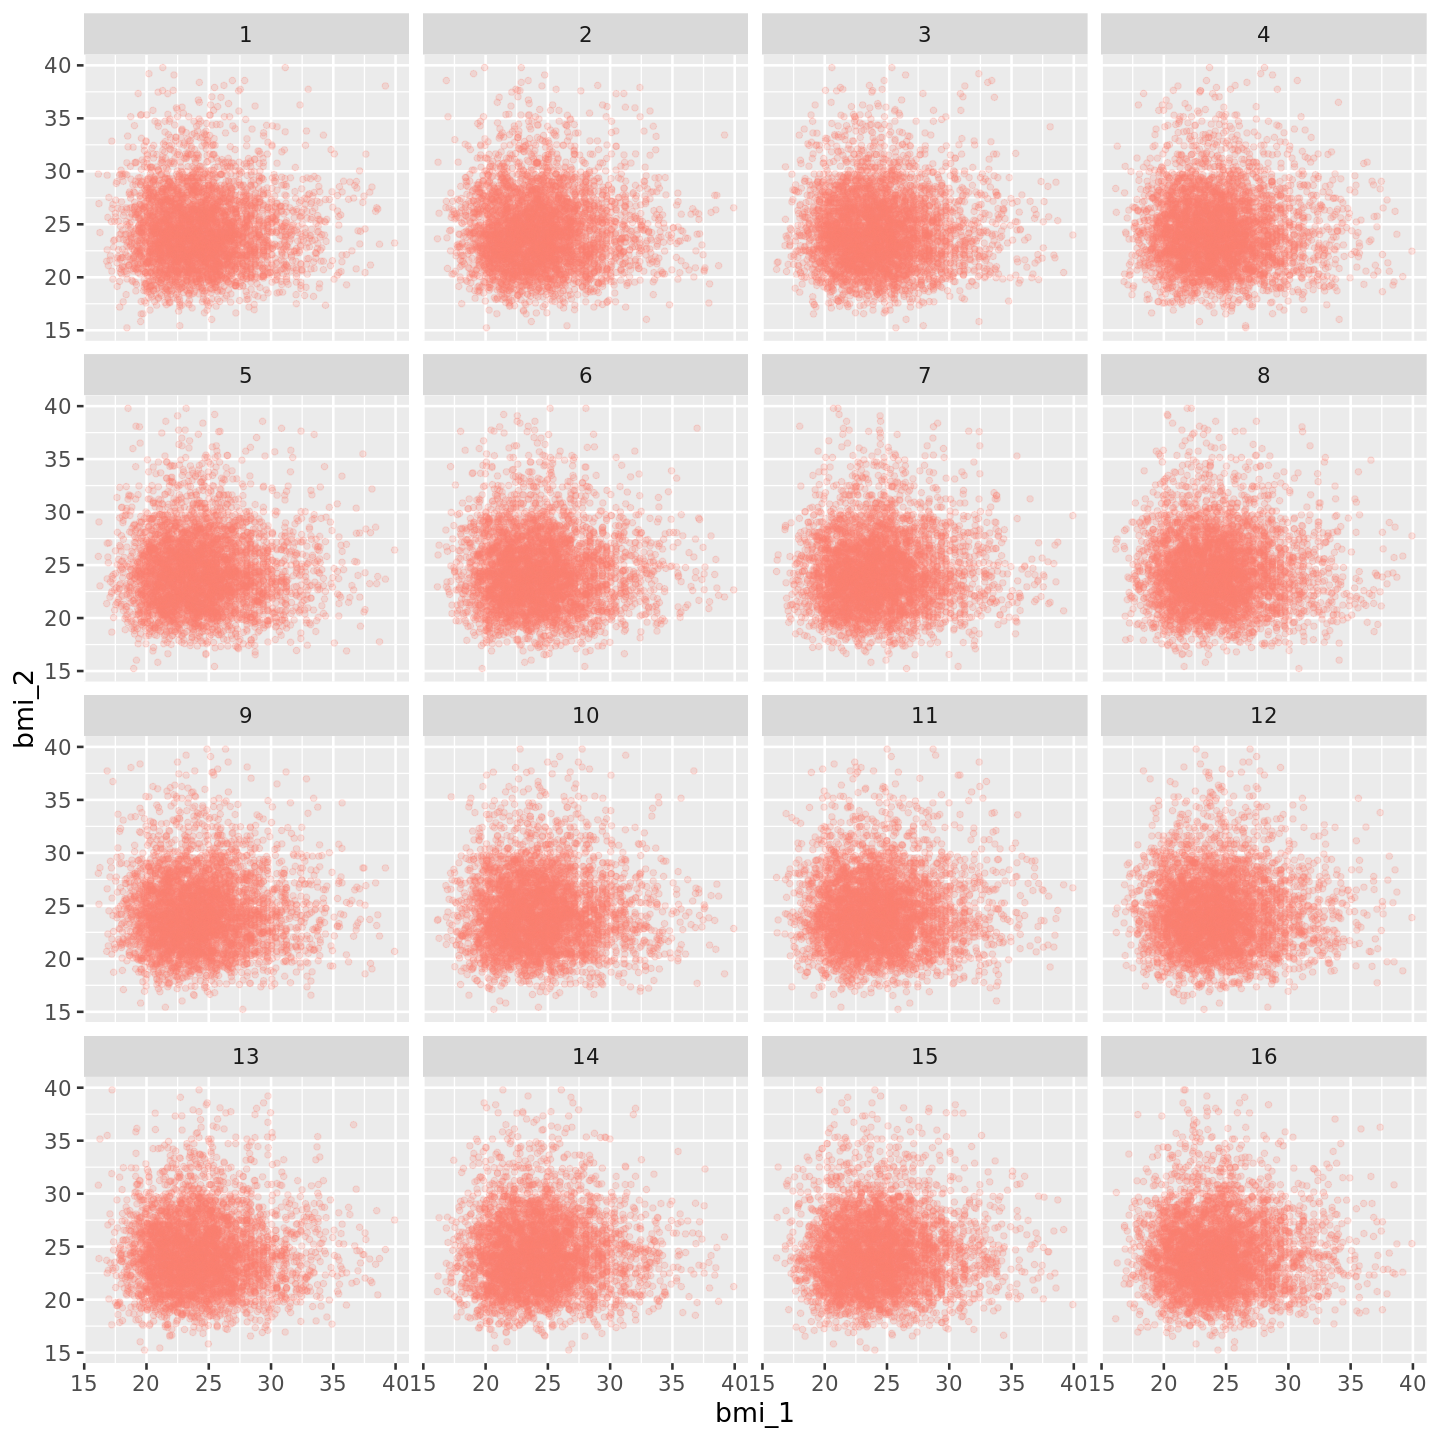

In [9]:
# set plot dimensions
options(repr.plot.width=12, repr.plot.height=12)

permute %>% 
filter(replicate <= 16) %>% 
ggplot(aes(x=bmi_1, y=bmi_2)) + 
  geom_point(color="salmon", alpha=0.2) + 
  facet_wrap(~replicate) +
  theme_grey(base_size=16)

We calculate the r statistic for each replicate by using the `cor_test` function from the `rstatix` library

In [10]:
# calculate correlation coefficient for each replicate

resample <- permute %>% 
            group_by(replicate) %>% 
            group_modify(~(.x %>% rstatix::cor_test(bmi_1, bmi_2) %>%
                           select(cor) %>%
                           rename(stat = cor))) %>% ungroup

head(resample)
tail(resample)

replicate,stat
<int>,<dbl>
1,0.0050
2,0.0019
3,-0.0065
4,-0.0300
5,0.0041
6,-0.0150


replicate,stat
<int>,<dbl>
995,-0.0110
996,0.0090
997,0.0046
998,0.0190
999,-0.0110
1000,0.0130


We now have a distribution of r statistic under the assumption that there is no correlation between the BMI measurements of the twins

### 1.3. Use the null distribution to calculate the p-value

Now that we have the r null distribution, we can check if any of these values exceed the r statistic in the data ```obs_stat_r```

In [11]:
resample <- resample %>% 
            mutate(exceed = if_else(abs(stat) >= abs(obs_stat_r), "Y","N") %>%
                            factor(levels=c("Y","N")))

resample %>% sample_n(10)

replicate,stat,exceed
<int>,<dbl>,<fct>
484,-0.00760,N
307,-0.01500,N
703,0.00770,N
815,0.01600,N
362,0.00800,N
739,-0.00500,N
873,-0.02000,N
944,0.00052,N
755,-0.00240,N


We can visualize the distribution of r statistic values and indicate those values that are equal or exceed the the observed r statistic in the data

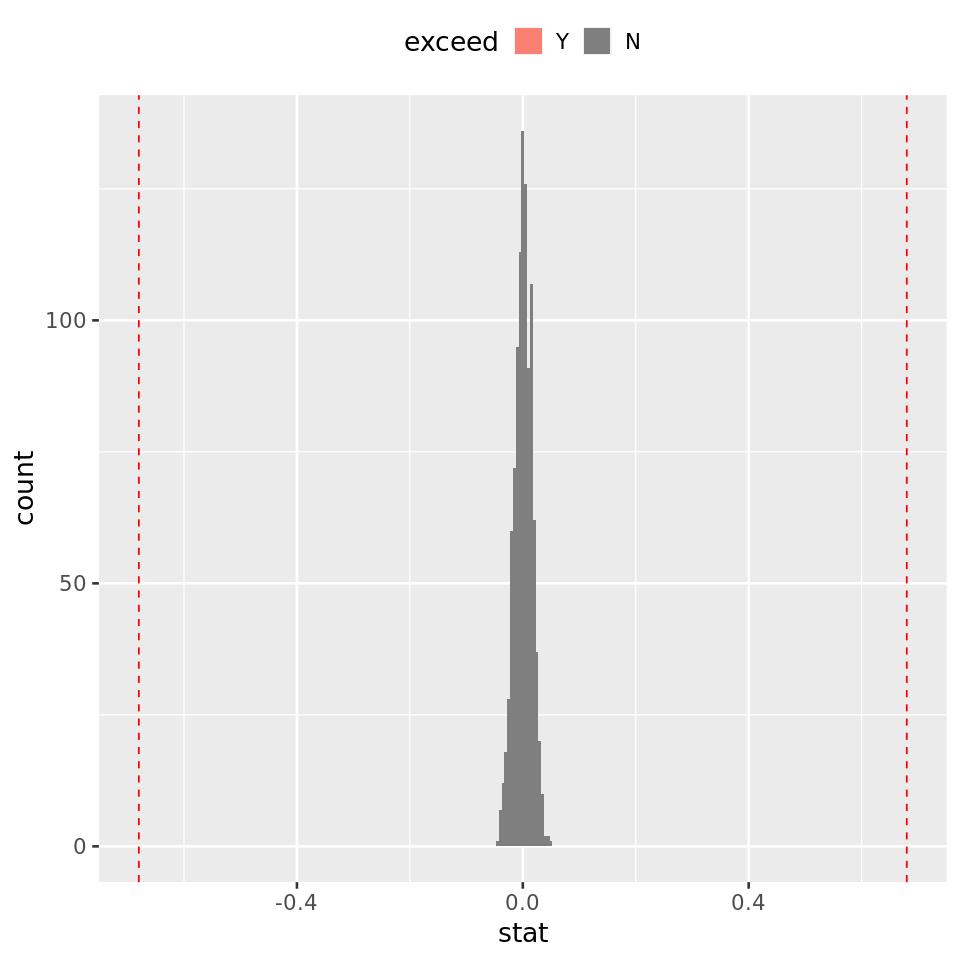

In [12]:
# set plot dimensions
options(repr.plot.width=8, repr.plot.height=8)

resample %>% ggplot(aes(x=stat, fill=exceed)) + 
               geom_histogram(binwidth=0.005) + 
               geom_vline(xintercept = obs_stat_r, color = "red", linetype="dashed") +
               geom_vline(xintercept = -obs_stat_r, color = "red", linetype="dashed") +
               scale_fill_manual(values=c("salmon", "grey50"), 
                                 labels=c("Y","N"), drop=FALSE) +
               theme_grey(base_size=16) +
               theme(legend.position = "top")

Finally, we can get the _p-value_ by calculating how many times the r statistic in the null distribution is equal/exceeds the observed r statistic

In [13]:
resample %>% summarize(num_resample = n(),
                       num_exceed = if_else(exceed == "Y", 1,0) %>% sum,
                       p_value = num_exceed/num_resample)

num_resample,num_exceed,p_value
<int>,<dbl>,<dbl>
1000,0,0


As the p-value is small, the observed correlation coefficient is unlikely to be consistent with the null hypothesis. Thus, the correlation between the BMI values of the twins is unlikely to be due to random chance

---
## 2. Analytical approach

In the analytical approach, the null distribution is not derived from resampling, but it is calculated from a theoretical formula that generalizes the distribution

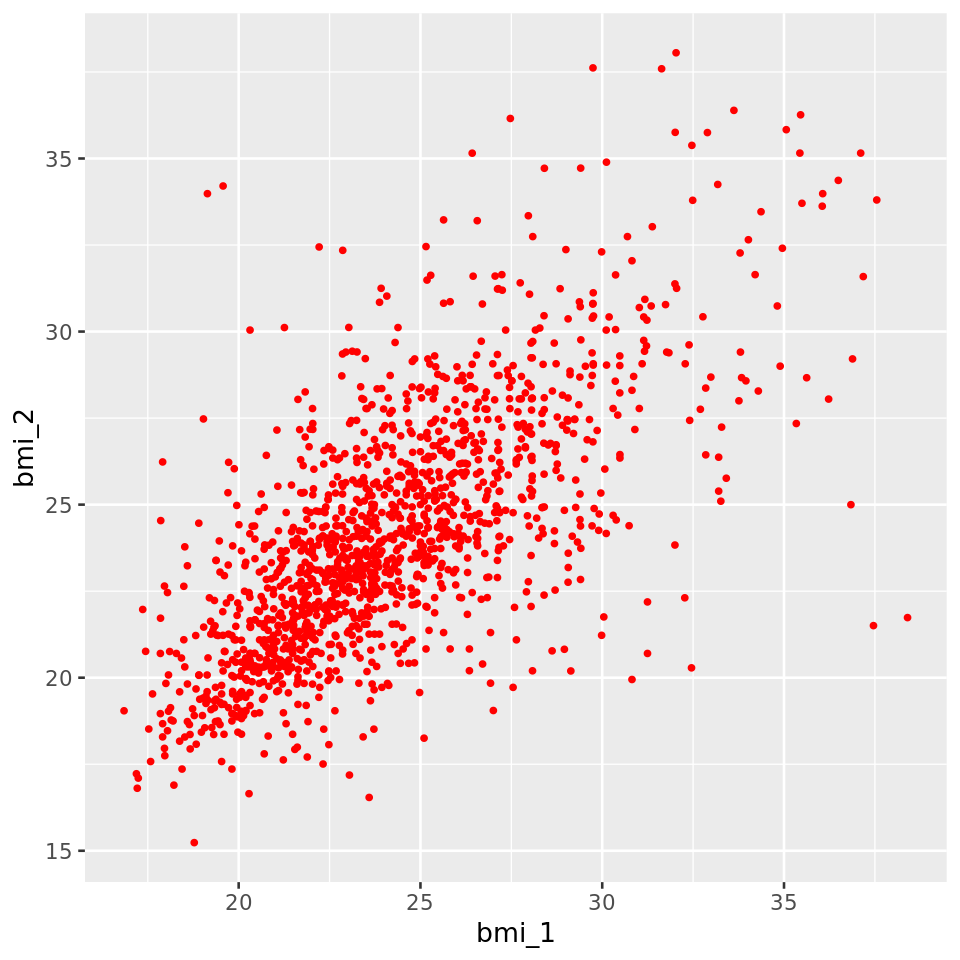

In [14]:
# set plot dimensions
options(repr.plot.width=8, repr.plot.height=8)

data_mz %>% 
ggplot(aes(x=bmi_1, y=bmi_2)) +
  geom_point(color="red") +
  theme_grey(base_size=16) +
  theme(legend.position = "top")

### 2.1. Calculate the test statistic

We can calculate the t-statistic by dividing the r coefficient by its standard error (SE)

$$t=\frac{r}{S E(r)}$$

The standard error (SE) of r is defined by

$$S E(r)=\sqrt{\frac{1-r^{2}}{\mathit{df}}}, \text{where } \mathit{df} = \text{number of points - 2}$$

Thus

$$t=\frac{r}{S E(r)}=\frac{r}{\sqrt{\frac{1-r^{2}}{\mathit{df}}}}=\frac{r \sqrt{\mathit{df}}}{\sqrt{1-r^{2}}}=r \sqrt{\frac{\mathit{df}}{1-r^2}}$$

See: https://stats.stackexchange.com/questions/400146/how-to-derive-the-formula-of-the-t-test-of-the-correlation-coefficient

In [15]:
num_pairs <- nrow(data_mz)
df <- num_pairs - 2

obs_stat_t <- obs_stat_r*sqrt(df/(1-obs_stat_r^2))

abs(obs_stat_t)

cor 
35.69084

### 2.2. Use the theoretical null distribution to calculate the p-value

The null t distribution is parameterized by the degrees of freedom `df`

- `df` = number of pairs - 2

$$
T \sim \frac{Z}{\sqrt{W /\mathit{df}}} \text{ where } Z \sim N(0,1) \text{, } W \sim \chi^{2}(\mathit{df})
$$

We use the `vdist_t_prob` function from `vistributions` library to plot the t-distribution and calculate the p-value

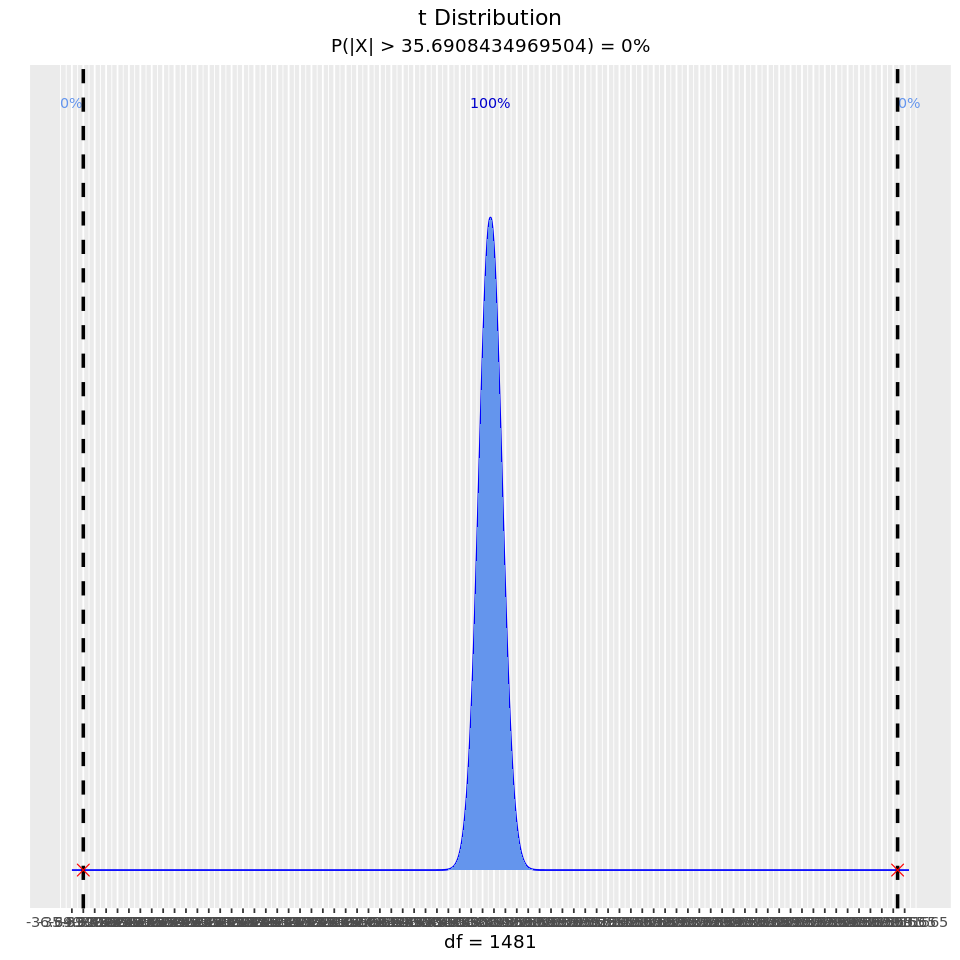

In [16]:
library(vistributions)

# set plot dimensions
options(repr.plot.width=8, repr.plot.height=8)

vdist_t_prob(perc = obs_stat_t, 
             df=df, 
             type = "both")

We see that the p-value ~ 0, which is the value we obtained through resampling

**Using a function**

We can also use the `cor_test` function from the `rstatix` library

In [17]:
data_mz %>% rstatix::cor_test(bmi_1, bmi_2)

var1,var2,cor,statistic,p,conf.low,conf.high,method
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
bmi_1,bmi_2,0.68,36.09961,3.01e-205,0.6560999,0.7103194,Pearson


---
## 3. Rank-based approach

The analytic approach based on theoretical distributions assumes a normal distribution of the data. This parametric approach may not work well under certain situations
- Small and/or skewed data that are not normally distributed
- Data that are ordinal in nature (e.g. pain score 1, ranking of food preferences)

We will use the same dataset to illustrate the **Spearman correlation test**
- Convert values to ranks
- Calculate the rank-based test statistic
- Calculate the p-value based on the null distribution

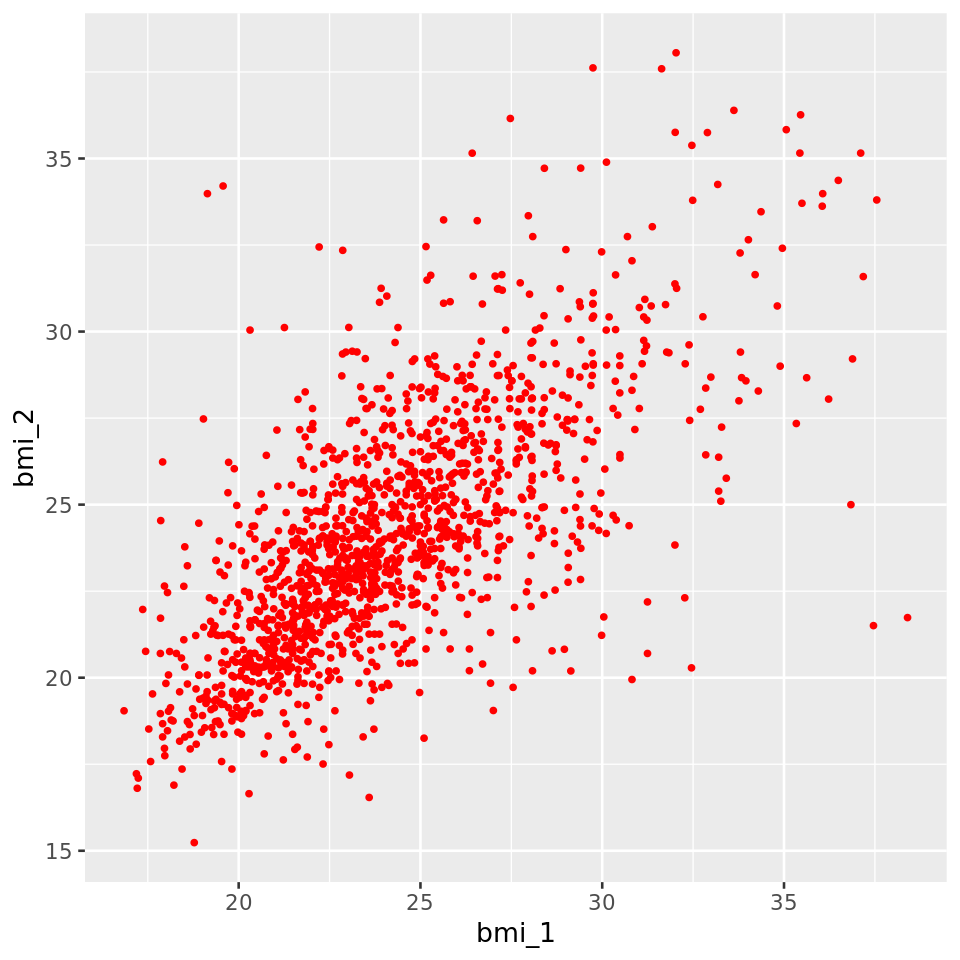

In [18]:
# set plot dimensions
options(repr.plot.width=8, repr.plot.height=8)

data_mz %>% 
ggplot(aes(x=bmi_1, y=bmi_2)) +
  geom_point(color="red") +
  theme_grey(base_size=16) +
  theme(legend.position = "top")

We can look at the QQ plots of both BMI variables

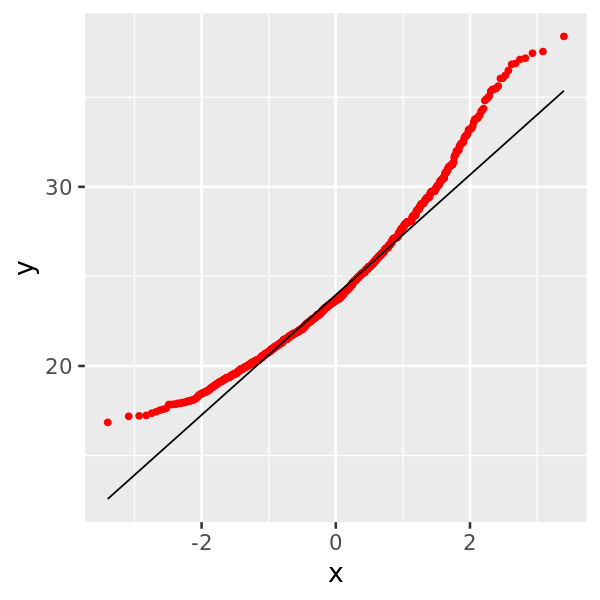

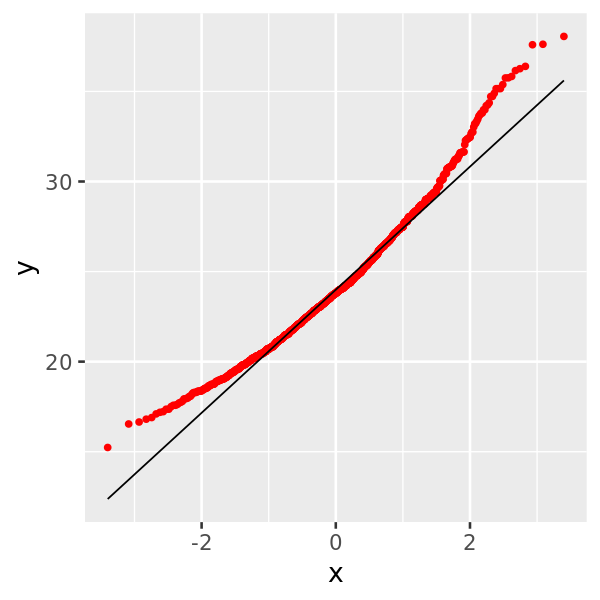

In [19]:
# set plot dimensions
options(repr.plot.width=5, repr.plot.height=5)

# QQ plot for bmi_1
data_mz %>% 
ggplot(aes(sample=bmi_1)) + 
       geom_qq(color="red") +
       geom_qq_line() +
       theme_grey(base_size = 16)

# QQ plot for bmi_2
data_mz %>% 
ggplot(aes(sample=bmi_2)) + 
       geom_qq(color="red") +
       geom_qq_line() +
       theme_grey(base_size = 16)

As we see that some of the values deviate from the normal distribution, we can use the rank-based approach

### 3.1. Calculate test statistic

We will calculate the rho correlation statistic
- Convert the values to ranks
- Calculate the sum of squared differences of ranks between the 2 groups
- Calculate the rho correlation based on the sum squared differences of ranks

In [20]:
data_rank <- data_mz %>%
             mutate(bmi1_rank=rank(bmi_1),
                    bmi2_rank=rank(bmi_2))

head(data_rank)

twinid,bmi_1,bmi_2,gender_1,gender_2,zyg,bmi1_rank,bmi2_rank
<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<dbl>,<dbl>
13,30.36735,31.63740,male,male,MZ,1397.5,1440.0
16,22.72044,22.12974,male,male,MZ,566.5,443.5
28,22.32143,24.09297,male,male,MZ,491.0,810.0
29,23.58833,23.50780,male,male,MZ,723.5,684.0
31,23.29123,24.22023,male,male,MZ,661.5,828.0
35,22.83737,24.91349,male,male,MZ,580.5,946.0


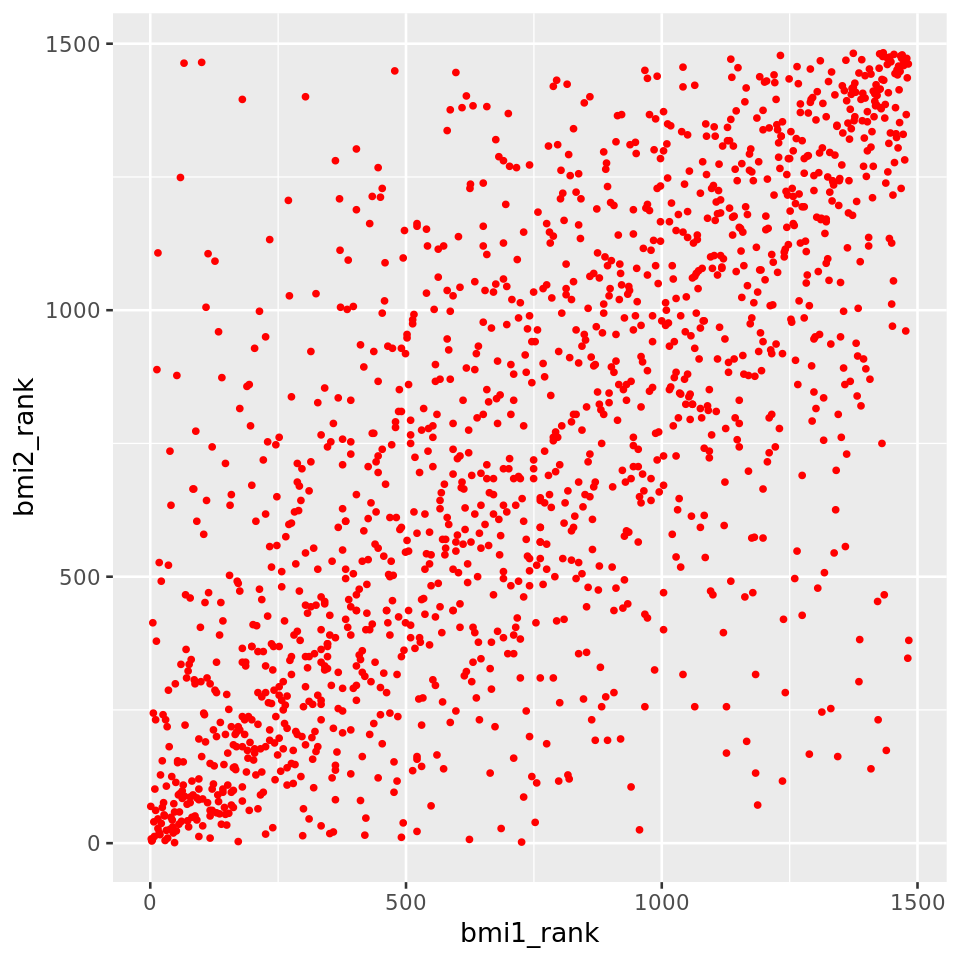

In [21]:
# set plot dimensions
options(repr.plot.width=8, repr.plot.height=8)

data_rank %>% 
ggplot(aes(x=bmi1_rank, y=bmi2_rank)) +
  geom_point(color="red") +
  theme_grey(base_size=16) +
  theme(legend.position = "top")

Next, we calculate the sum of squared differences between ranks of 2 groups

In [22]:
sum_d2 <- data_rank %>% 
          mutate(d = bmi1_rank-bmi2_rank,
                 d2 = d^2) %>%
          summarize(sum_d2 = sum(d2)) %>%
          pull(sum_d2)

sum_d2

[1] 165456953

Recall that the correlation measure is

$$\begin{aligned}
r_{X Y} &=\frac{\text { Degree to which } X \text { and } Y \text { vary together }}{\text { Degree to which } X \text { and } Y \text { vary separately }} \\
&=\frac{\operatorname{Cov}(X, Y)}{\sqrt{\operatorname{Var}(X)} \sqrt{\operatorname{Var}(Y)}}
\end{aligned}$$

For ranks, the correlation measure (rho) is equivalent to

$$\rho=1-\frac{6 \sum d_{i}^{2}}{n\left(n^{2}-1\right)}$$

$$
\begin{align}
\text{where } d &= \text{difference in ranks between 2 groups} \\
n &= \text{number of paired samples}
\end{align}
$$

For details, see: https://stats.stackexchange.com/questions/89121/prove-the-equivalence-of-the-following-two-formulas-for-spearman-correlation

In [23]:
n <- nrow(data_rank)

obs_stat_rho <- 1 - 6*sum_d2/(n*(n^2-1))

obs_stat_rho

[1] 0.6956222

**Using a function**

We can also use the `cor_test` function from the `rstatix` library by specifying the `method = "spearman"` option

In [24]:
data_mz %>% 
rstatix::cor_test(bmi_1,bmi_2, 
                  method="spearman") %>%
pull(cor)

rho 
0.7

### 3.2. Use the null distribution of ranks to find the p-value

Now that we have the test statistic, we will need to generate a null distribution to compare it to.

#### Using a resampling approach

To get an intuition of the null distribution of rho statistic, we can simulate the null distribution by permuting the different ranks in the groups and calculating the rho statistic for each replicate
- Note that we do not resample from the data but generate the distribution of ranks from a range consistent with the number of observations

We calculate the rho statistic for each replicate to generate the null distribution and check which values in the null distribution equal or exceed the observed rho statistic in the data

In [25]:
# calculate rho statistic for 1 sample of random pair of ranks
sample_once <- function(n) {
    
    rank1 <- sample(seq(1,n),n)
    rank2 <- sample(seq(1,n),n)
    d2 <- (rank1 - rank2)^2
    p <- 6*sum(d2)/(n*(n^2-1))
    return(1-p)
    
}

# resample to generate null distribution and check for extreme values
n_sample <- nrow(data)
n_replicates <- 10000

resample <- tibble(rho=as.numeric(replicate(n_replicates,sample_once(n_sample)), simplify=F)) %>%
            mutate(exceed=ifelse(rho>=abs(obs_stat_rho),"Y","N") %>%
            factor(levels=c("Y","N")))

head(resample)

rho,exceed
<dbl>,<fct>
-0.0009176393,N
-0.0246325499,N
-0.0196482671,N
0.0098887939,N
0.0150996853,N
-0.0232152001,N


We can plot the null distribution and and see how often the rho statistic in the null distribution equals or exceeds what we observe in the data

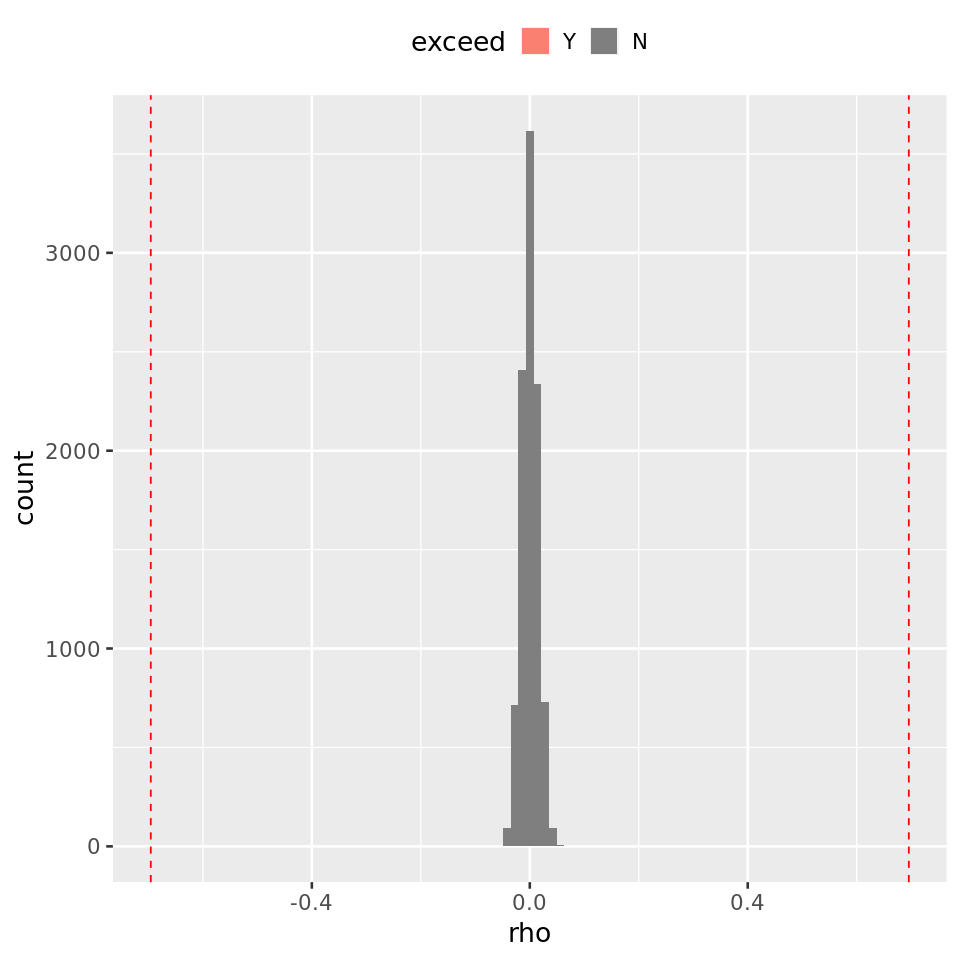

In [26]:
# set plot dimensions
options(repr.plot.width=8, repr.plot.height=8)

resample %>% 
ggplot(aes(x=rho,fill=exceed)) + 
  geom_histogram(bins=100) +
  geom_vline(xintercept = obs_stat_rho, color = "red", linetype="dashed") +
  geom_vline(xintercept = -obs_stat_rho, color = "red", linetype="dashed") +
  scale_fill_manual(values=c("salmon", "grey50"), 
                    labels=c("Y","N"), drop=FALSE) +
  theme_grey(base_size=16) +
  theme(legend.position = "top")

In [27]:
resample %>% summarize(num_resample = n(),
                       num_exceed = if_else(exceed == "Y", 1,0) %>% sum,
                       p_value = num_exceed/num_resample)

num_resample,num_exceed,p_value
<int>,<dbl>,<dbl>
10000,0,0


As the p-value is small, the observed rho statistic is unlikely to be consistent with the null hypothesis. Thus, the rank correlation between the BMI values of the twins is unlikely to be due to random chance

#### Using a theoretical null distribution

Analytically, we can use the null t-distribution that is parameterized by `df`, where 
- df = number of pairs - 2

We can calculate the t-statistic from the rho statistic

$$t=\rho \sqrt{\frac{\mathit{df}}{1-\rho^{2}}}$$

$$
\begin{align}
\text{where }\mathit{df} &=\text{number of pairs - 2} \\
\rho &= \text{Spearman rho correlation coefficient}
\end{align}
$$

In [28]:
num_pairs <- nrow(data_mz)
df <- num_pairs - 2

obs_stat_t <- obs_stat_rho*sqrt((num_pairs - 2)/(1-obs_stat_rho^2))

obs_stat_t

[1] 37.26318

We use the `vdist_t_prob` function from `vistributions` library to plot the t-distribution and calculate the p-value

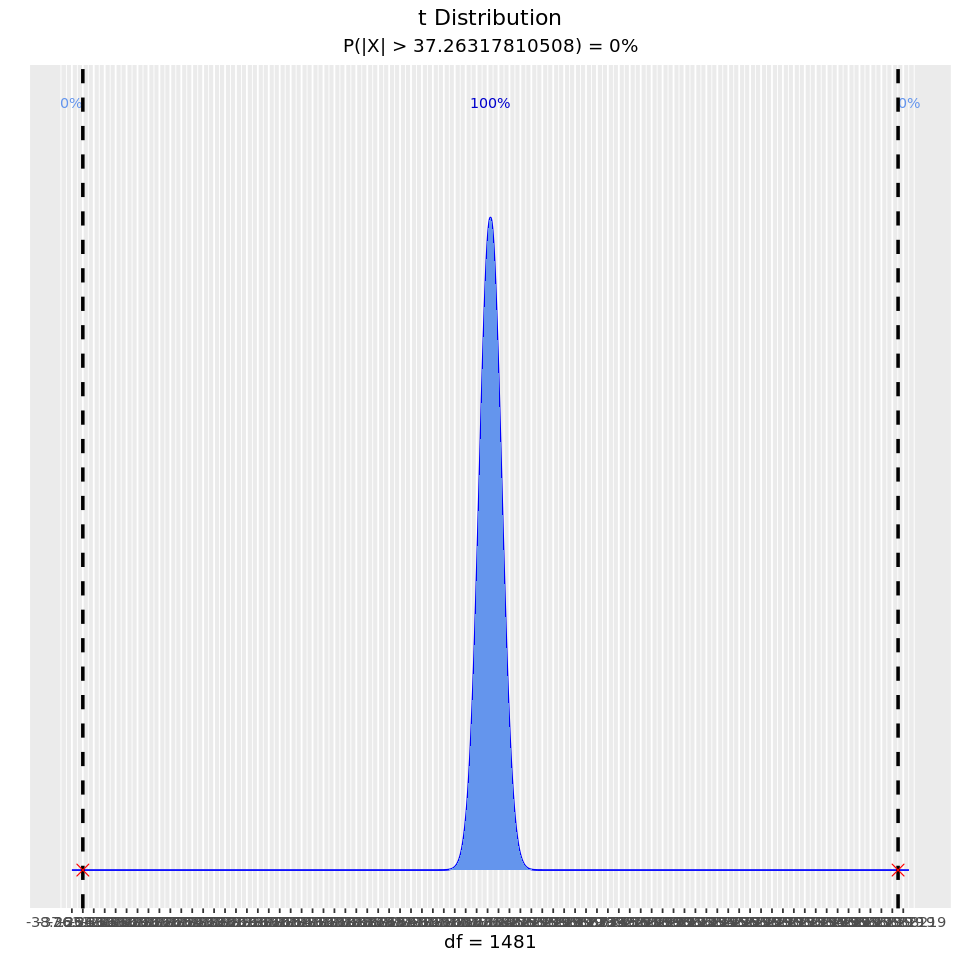

In [29]:
library(vistributions)

# set plot dimensions
options(repr.plot.width=8, repr.plot.height=8)

vdist_t_prob(perc = obs_stat_t, 
             df=df, 
             type = "both")

We see that the p-value ~ 0, which is the value we obtained through resampling

**Using a function**

We can also use the `cor_test` function from the `rstatix` library by specifying the `method = "spearman"` option

In [30]:
data_mz %>% rstatix::cor_test(bmi_1,
                              bmi_2, 
                              method="spearman")

var1,var2,cor,statistic,p,method
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>
bmi_1,bmi_2,0.7,165457624,5.76e-215,Spearman


---
## A digression

We can make use of the correlation coefficients in twins to make inferences about the heritability of a trait. In the dataset, there are
- Monozygotic (MZ) twins that share 100% of the genes
- Dizygotic (DZ) twins that share 50% of the genes

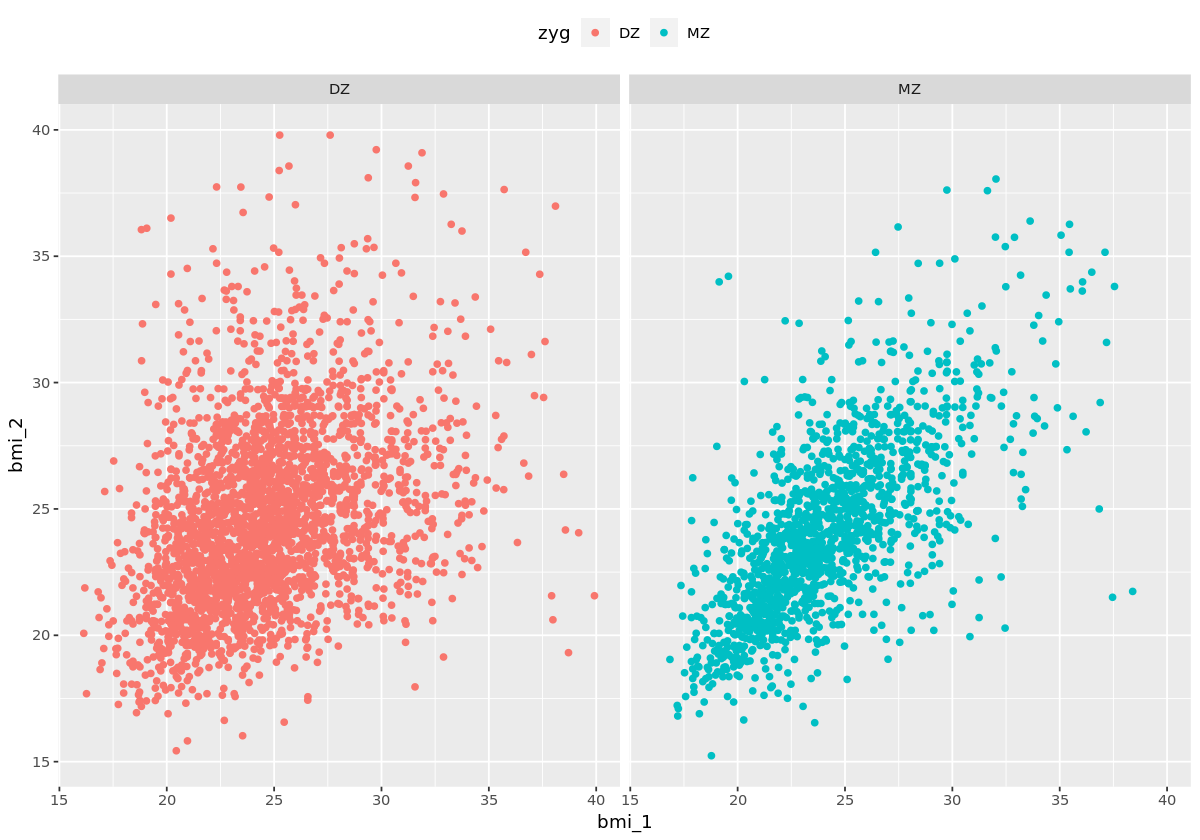

In [31]:
# set plot dimensions
options(repr.plot.width=10, repr.plot.height=7)

data %>% 
ggplot(aes(x=bmi_1, y=bmi_2, color=zyg)) +
  geom_point() +
  facet_wrap(~zyg) + 
  theme(legend.position = "top")

We can see that the correlation for MZ twins appears to be higher than DZ twins and we can calculate the r statistic using the `cor_test` function

In [32]:
cor_twins <- data %>% 
             group_by(zyg) %>%
               rstatix::cor_test(bmi_1, bmi_2) %>%
               as_tibble %>%
             ungroup %>%
             select(zyg, cor) %>% 
             pivot_wider(names_from = "zyg", values_from = "cor")

cor_twins

DZ,MZ
<dbl>,<dbl>
0.37,0.68


We can make use of the fact that DZ twins have share half the genetic identity compared to MZ twins to calculate the heritability index $H_2$

![test_correlation_h2.png](images/test_correlation_h2.png)

In [33]:
cor_twins %>% 
summarize(heritability_index = 2 * (MZ - DZ))

heritability_index
<dbl>
0.62


We can see that BMI has a large heritable component based on the twin correlation study

---
# Application: Statistical plotting

We will use the `ggstatsplot` library. For details see: https://indrajeetpatil.github.io/ggstatsplot/

In [ ]:
library(ggstatsplot)

In [ ]:
library(tidyverse)

# Twin data from https://github.com/kkholst/mets
data <- read_csv("https://raw.githubusercontent.com/kennethban/dataset/main/twinbmi.csv")

data <- data %>% 
        mutate(gender = as.factor(gender),
                  zyg = as.factor(zyg)) %>%
        pivot_wider(id_cols ="tvparnr", 
                    names_from = "num", 
                    values_from = c("bmi","gender","zyg")) %>%
        rename(twinid = tvparnr, 
               zyg = zyg_1) %>%
        select(-zyg_2) %>%
        drop_na()

data_mz <- data %>%
           filter(zyg=="MZ")

head(data_mz)

## 1. Parametric plot (Pearson's Correlation)

We will make a scatterplot looking at the correlation between 2 groups with the parametric Pearson's correlation index using the `ggscatterstats` function from `ggstatsplot`
- `x`: group 1 values
- `y`: group 2 values
- `type`: default is `parametric`
- `marginal`: set to FALSE to omit the marginal plots

For details, see: https://indrajeetpatil.github.io/ggstatsplot/reference/ggscatterstats.html

In [ ]:
# set plot dimensions
options(repr.plot.width=10, repr.plot.height=10)

data_mz %>% 
ggscatterstats(x = bmi_1, 
               y = bmi_2,
               marginal = FALSE) + 
  theme_grey(base_size=16)

## 2. Non-parametric plot (Spearman's Rank Correlation)

We will make a scatterplot looking at the correlation between 2 groups with the non-parametric Spearman's rank correlation index using the `ggscatterstats` function from `ggstatsplot`
- `x`: group 1 values
- `y`: group 2 values
- `type`: set to `nonparametric`
- `marginal`: set to FALSE to omit the marginal plots

For details, see: https://indrajeetpatil.github.io/ggstatsplot/reference/ggscatterstats.html

In [ ]:
data_mz %>% 
ggscatterstats(x = bmi_1, 
               y = bmi_2,
               type="nonparametric",
               marginal = FALSE) + 
  theme_grey(base_size=16)

---
## Exercise - Correlating 2 measures

For this exercise, we will use the Framingham heart dataset

In [ ]:
library(tidyverse)

# load data
data_plot <- read_csv("https://raw.githubusercontent.com/kennethban/dataset/main/framingham.csv")

# recap of what was done
data_plot <- data_plot %>% 
             rename(sex = male) %>%
             mutate(sex = as.factor(sex),
                    age = as.integer(age),
                    education = as.factor(education),
                    currentSmoker = as.factor(currentSmoker),
                    cigsPerDay = as.integer(cigsPerDay),
                    BPMeds = as.factor(BPMeds),
                    prevalentStroke = as.factor(prevalentStroke),
                    prevalentHyp = as.factor(prevalentHyp),
                    diabetes = as.factor(diabetes),
                    totChol = as.integer(totChol),
                    heartRate = as.integer(heartRate),
                    TenYearCHD = as.factor(TenYearCHD)
                    )

data_plot <- data_plot %>% 
             mutate(glucose = round(glucose/18, digits=1)) %>% # mg/dL to mmol/L
             mutate(totChol = round(totChol/39, digits=1))     # mg/dL to mmol/L

head(data_plot)

### Part 1

Plot the distributions of `totChol` and `BMI` using `ggplot` from `tidyverse`

In [ ]:
library(tidyverse)

# start here

In [ ]:
# solution

# set plot dimensions
options(repr.plot.width=8, repr.plot.height=8)

data_plot %>% 
ggplot(aes(x=totChol)) +
  geom_histogram() +
  theme_grey(base_size=16)

data_plot %>% 
ggplot(aes(x=BMI)) +
  geom_histogram() +
  theme_grey(base_size=16)

### Part 2

Generate statistical plots showing the correlation between `totChol` and `BMI` using `ggscatterstats` from `ggstatsplot`
- Explain your choice of test
- State the effect size, 95% CI and p-value

In [ ]:
library(ggstatsplot)

# start here

In [ ]:
# solution

# set plot dimensions
options(repr.plot.width=8, repr.plot.height=8)

data_plot %>% 
ggscatterstats(x=BMI, 
              y=totChol,
              marginal=FALSE) +
  theme_grey(base_size=16)